## 1. Install Dependencies and Setup

In [1]:
# ! pip install opencv-python

In [2]:
# Used to check the packages installed
! pip list

Package                       Version
----------------------------- ------------
absl-py                       2.1.0
aiohttp                       3.9.1
aiosignal                     1.3.1
altair                        5.0.1
aniso8601                     9.0.1
annotated-types               0.5.0
ansi2html                     1.8.0
anyio                         3.7.1
apiclient                     1.0.4
asttokens                     2.2.1
astunparse                    1.6.3
atomicwrites                  1.4.1
attrs                         23.1.0
backcall                      0.2.0
backoff                       2.2.1
beautifulsoup4                4.12.2
blinker                       1.6.2
botocore                      1.34.24
bs4                           0.0.1
cachetools                    5.3.1
certifi                       2023.7.22
chardet                       4.0.0
charset-normalizer            3.2.0
click                         8.1.6
cloudmersive-image-api-client 3.0.1
cloudpickle


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1.1 Install Libraries

In [14]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imghdr
import pandas as pd
from PIL import Image

### 1.2 Remove Dodgy images

### 1.3 Load Data

In [4]:
image_dataset = pd.read_parquet("0000.parquet")

In [5]:
len(image_dataset)

3107

In [22]:
image_dataset.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


### 1.4 Splitting the Data

In [28]:
from sklearn.model_selection import train_test_split

# Split the dataset into images and labels
images = [image for image in image_dataset]
labels = [label for label in image_dataset]

# Split the images and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert the lists to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle and batch the datasets
batch_size = 100
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)



In [27]:
# Checking the shape of the dataset
print(f"The shape of the image column is {image_dataset['image'].shape}")
print(f"The shape of the label column is {image_dataset['label'].shape}")

The shape of the image column is (3107,)
The shape of the label column is (3107,)


# 2. Data Preprocessing

- This process contains:

    a) Data Standardization
    b) Data Augmentation

### 2.1 Data Augmentation

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

image_height = 256
image_width = 256

train_data_augmentation = keras.Sequential(
    [
        layers.RandomCrop(image_height, image_width),
        layers.Rescaling(scale=1.0 / 256, offset=-1),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="train_data_augmentation",
)

val_data_augmentation = keras.Sequential(
    [
        layers.CenterCrop(image_height, image_width),
        layers.Rescaling(scale=1.0 / 256, offset=-1),
    ],
    name="val_data_augmentation",
)

In [45]:
import tensorflow as tf
# Define preprocessing functions
def preprocess_train(example_batch):
    images = train_data_augmentation(example_batch["image"])
    return {"image": images}, example_batch["label"]

def preprocess_val(example_batch):
    images = val_data_augmentation(example_batch["image"])
    return {"image": images}, example_batch["label"]

# Assuming you have your train_dataset and val_dataset already defined
# Apply preprocessing functions to the datasets
transformed_train_dataset = train_dataset.map(preprocess_train)
transformed_val_dataset = test_dataset.map(preprocess_val)


TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__preprocess_train() takes 1 positional argument but 2 were given


# 3. Create a Deep Model

In [ ]:
# Importing necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
# Create the model
model = Sequential()

In [ ]:
from tensorflow.keras import layers
# Create CNN Architecture
model = Sequential([
    layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(image_height, image_width, num_channels)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Adding dropout regularization to deal with overfitting
    layers.Dense(num_classes, activation='softmax')
])


In [ ]:
# Build the model
model.build(input_shape=(batch_size, image_height, image_width, num_channels))

In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)     

# 4. Train the Model

In [ ]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[tensorboard_callback])

Epoch 1/10


20/20 [==============================] - 235s 10s/step - loss: 12.6226 - accuracy: 0.3715 - val_loss: 2.5542 - val_accuracy: 0.2017
Epoch 2/10
20/20 [==============================] - 192s 9s/step - loss: 1.7155 - accuracy: 0.3130 - val_loss: 2.5036 - val_accuracy: 0.2017
Epoch 3/10
20/20 [==============================] - 181s 9s/step - loss: 1.5212 - accuracy: 0.3224 - val_loss: 3.1667 - val_accuracy: 0.2017
Epoch 4/10
20/20 [==============================] - 174s 9s/step - loss: 1.5056 - accuracy: 0.3161 - val_loss: 3.8354 - val_accuracy: 0.2017
Epoch 5/10
20/20 [==============================] - 175s 9s/step - loss: 1.4961 - accuracy: 0.3349 - val_loss: 4.5128 - val_accuracy: 0.2017
Epoch 6/10
20/20 [==============================] - 178s 9s/step - loss: 1.4913 - accuracy: 0.3307 - val_loss: 5.4223 - val_accuracy: 0.2017
Epoch 7/10
20/20 [==============================] - 194s 10s/step - loss: 1.4765 - accuracy: 0.3328 - val_loss: 5.7691 - val_accuracy: 0.2017
Epoch 8/

## 4.1 Visualize the Training Results

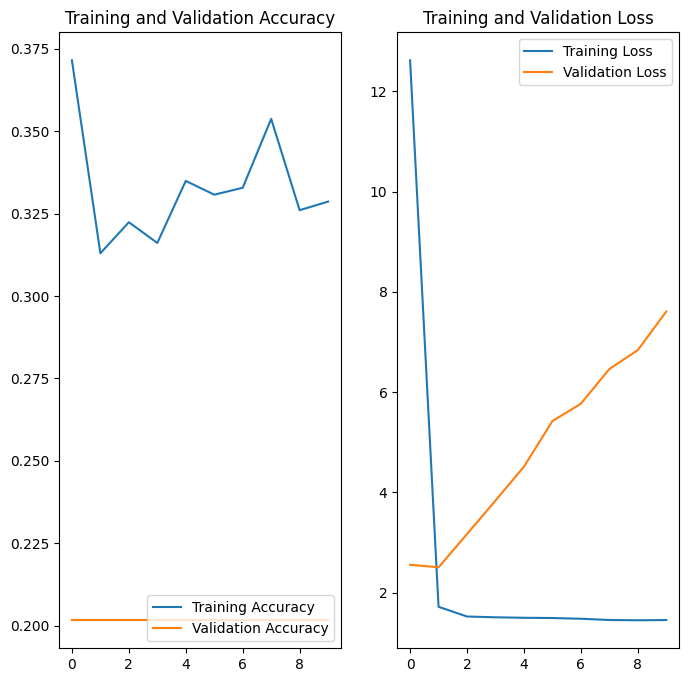

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 5. Model Prediction

In [ ]:
glass_path = 'Paper.jpg'

img = tf.keras.utils.load_img(
    glass_path, target_size=(image_height, image_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 601ms/step


NameError: name 'classes' is not defined